<a href="https://colab.research.google.com/github/Salma-Jamal/Arabic-Dialect-Identification/blob/main/QADI-Experiments/Qadi_Finetune_ARBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
!pip install -q transformers
!pip install -q datasets
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from transformers import TrainerCallback
from copy import deepcopy
from datasets import load_metric
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt 
import plotly.graph_objs as go 
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np        
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import pandas as pd
from PIL import Image
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report



#Download Data

In [ ]:
!gdown https://drive.google.com/uc?id=1L52IF87VWMepCgeu1GejE_AhE1x6PSXT

Downloading...
From: https://drive.google.com/uc?id=1L52IF87VWMepCgeu1GejE_AhE1x6PSXT
To: /content/sample.csv
100% 11.4M/11.4M [00:00<00:00, 175MB/s]


# Read Data

In [ ]:
df = pd.read_csv('/content/sample.csv')

In [ ]:
def seed_everything(seed=1234):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['dialect'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
df_train = pd.DataFrame({'tweet':X_train,'dialect':y_train})
df_test = pd.DataFrame({'tweet':X_test,'dialect':y_test})
df_val = pd.DataFrame({'tweet':X_val,'dialect':y_val})

In [ ]:
df_train.head()

,tweet,dialect
96586,سندرلاند الاخير والفريق قيمه اسعار اللاعبين ما...,KW
57784,اللوغه العرابيه تفصصلك بعيد,LY
17345,اكييد التقوااس التقوااس التقوااس شاء الله شي ه...,MA
15954,اعياد بيروت كلنا نعرف مين منظمو ليش نحكي تونس ...,LB
85258,تامري امر اقل واجب,YE


In [ ]:
df_val.head()

,tweet,dialect
94532,اعرف شخص يتحدث تخصصه العملي يقول تشوف اللي يصي...,AE
18306,تطلع اشاعات,QA
22250,اين شخص شخصه يغرد علي موضوع العلاقات والارتباط...,LY
25757,عجباك الاجازه هيك عندك صرت جزء ديكور البيت,PL
4650,للاسف حاولت وللحين مارجع,SA


In [ ]:
len(df_train) , len(df_val) , len(df_test)

(72000, 8000, 20000)

#Preparing data and model

In [ ]:
df_train['dialect'].unique()

array(['KW', 'LY', 'MA', 'LB', 'YE', 'EG', 'QA', 'JO', 'OM', 'AE', 'IQ',
       'BH', 'PL', 'DZ', 'SA', 'SD', 'TN', 'SY'], dtype=object)

In [ ]:
class_name = ['KW', 'LY', 'MA', 'LB', 'YE', 'EG', 'QA', 'JO', 'OM', 'AE', 'IQ',
       'BH', 'PL', 'DZ', 'SA', 'SD', 'TN', 'SY']

def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(14, 10))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="twilight",cbar=False)
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Dialect')
  plt.xlabel('Predicted Dialect');
  plt.title('Confusion Matrix of Predictions')

In [ ]:
encode_labels = {d: i for i, d in enumerate(df_train['dialect'].unique())}

In [ ]:
df_train['dialect'] = df_train['dialect'].map(encode_labels)
df_val['dialect'] = df_val['dialect'].map(encode_labels)
df_test['dialect'] = df_test['dialect'].map(encode_labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabert", num_labels=len(df_train['dialect'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabert')

In [ ]:
sequence = []
for i in df_train['tweet'].tolist():
  sequence.append(len(tokenizer.encode(i)))
max_seq_len = max(sequence)

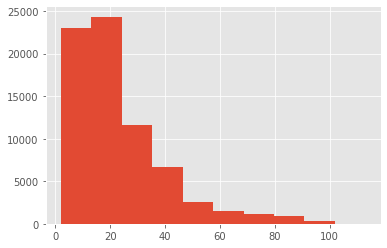

In [ ]:
plt.hist(sequence);

In [ ]:
max_seq_len = 80

In [ ]:
train = tokenizer(df_train['tweet'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
val = tokenizer(df_val['tweet'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
test = tokenizer(df_test['tweet'].to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [ ]:
train_labels = df_train['dialect']
val_labels = df_val['dialect']
test_labels = df_test['dialect']

In [ ]:
class NADIDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)


In [ ]:
ds_train = NADIDataset(train, train_labels)
ds_val =  NADIDataset(val, val_labels)
ds_test =  NADIDataset(test, test_labels)

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  f1 = f1_score(labels, predictions, average='macro')
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=6,              
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,      
    evaluation_strategy = "epoch",        
    save_strategy = 'epoch',
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=ds_train,
    eval_dataset=ds_val,                       
    compute_metrics=compute_metrics
)

#Training

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 72000
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6750
  Number of trainable parameters = 135207186


Epoch,Training Loss,Validation Loss,Accuracy
1,2.164600,1.945352,0.373500
2,1.785600,1.781949,0.429125
3,1.424800,1.730634,0.467625
4,1.072500,1.789347,0.484000
5,0.798600,1.903877,0.495375
6,0.607600,1.992997,0.495250


***** Running Evaluation *****
  Num examples = 8000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1125
Configuration saved in ./results/checkpoint-1125/config.json
Model weights saved in ./results/checkpoint-1125/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-2250
Configuration saved in ./results/checkpoint-2250/config.json
Model weights saved in ./results/checkpoint-2250/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-3375
Configuration saved in ./results/checkpoint-3375/config.json
Model weights saved in ./results/checkpoint-3375/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-4500
Configuration saved in ./results/checkpoint-4500/config.json
Model weights saved in ./results/checkpoint-4500/pytorch_mo

TrainOutput(global_step=6750, training_loss=1.339705157244647, metrics={'train_runtime': 5427.0995, 'train_samples_per_second': 79.601, 'train_steps_per_second': 1.244, 'total_flos': 1.776254759424e+16, 'train_loss': 1.339705157244647, 'epoch': 6.0})

# Testing

In [ ]:
preds = trainer.predict(ds_test)

***** Running Prediction *****
  Num examples = 20000
  Batch size = 32


In [ ]:
y_pred = [ np.argmax(i, axis=-1) for i  in preds[0]]
y_test = ds_test.labels

In [ ]:
accuracy_score(y_test, y_pred)

0.5028

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.46907241651607695

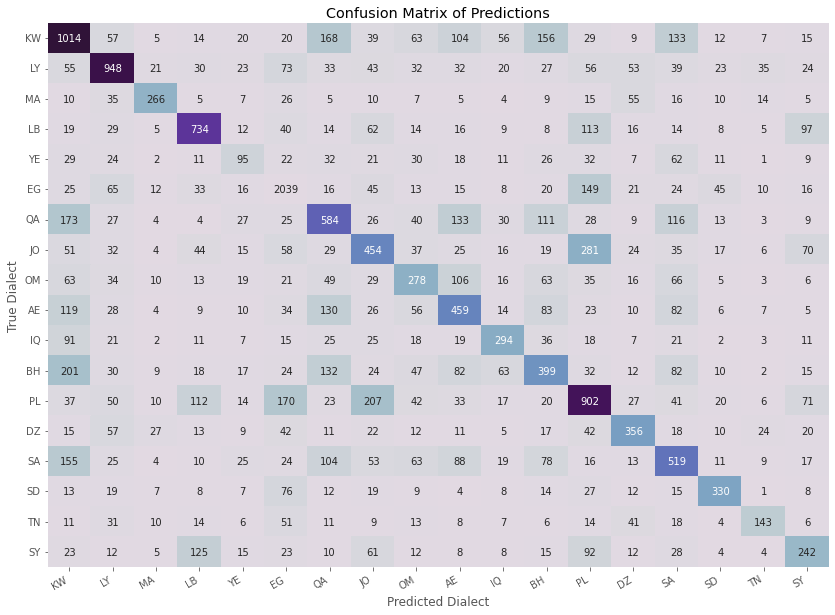

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

## Save model checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.save_model('./Qadi-Finetune-ARBERT')

Saving model checkpoint to ./Qadi-Finetune-ARBERT
Configuration saved in ./Qadi-Finetune-ARBERT/config.json
Model weights saved in ./Qadi-Finetune-ARBERT/pytorch_model.bin


In [ ]:
!cp -r /content/Qadi-Finetune-ARBERT /content/drive/MyDrive/Qadi-Finetune-ARBERT

#Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("aubmindlab/bert-base-arabert")

In [ ]:
inf_model = AutoModelForSequenceClassification.from_pretrained("/content/Qadi-Finetune-ARBERT")
inf_trainer = Trainer(
    model=inf_model,                       
    args=training_args,                 
    train_dataset=ds_train,                     
    compute_metrics=compute_metrics
)
inf_preds = inf_trainer.predict(ds_test)

In [ ]:
y_pred = [ np.argmax(i, axis=-1) for i  in inf_preds[0]]
y_test = ds_test.labels

In [ ]:
print('F1-Score =  ',f1_score(y_test, y_pred, average='macro')*100,"%")
print('Accuracy = ',accuracy_score(y_test, y_pred)*100,"%")

F1-Score =   46.9072416516077 %
Accuracy =  50.28 %


In [ ]:
def predict(Trainer,tokenizer,sentence):
  data = [[0, sentence]]
  inf_df = pd.DataFrame(data, columns = ['dialect', 'text'])
  test_labels = inf_df['dialect']
  test_encodings = tokenizer(inf_df['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
  test_dataset = NADIDataset(test_encodings, test_labels)
  pred = Trainer.predict(test_dataset)
  pred = np.argmax(pred[0],axis=-1)
  return list(encode_labels.keys())[list(encode_labels.values()).index(pred[0])]

In [ ]:
predict(inf_trainer,tokenizer,"والنبي انتي عسل ودمك زي السكر")

***** Running Prediction *****
  Num examples = 1
  Batch size = 32


'EG'

In [ ]:
predict(inf_trainer,tokenizer,"شكله زي هيك")

***** Running Prediction *****
  Num examples = 1
  Batch size = 32


'PL'